In [9]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pickle
import json
from collections import OrderedDict
import copy
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
def income_cat_nhts(row):
    if row['HHFAMINC'] >7: return "gt100"
    elif row['HHFAMINC'] >4: return "gt35-lt100"
    return "lt35"
    
def age_cat_nhts(row):
    if row['R_AGE_IMP' ]<= 19: return "19 and under"
    elif row['R_AGE_IMP' ] <= 35: return "20 to 35"
    elif row['R_AGE_IMP' ] <= 60: return "35 to 60"
    return "above 60"
    
def children_cat_nhts(row):
    if row['LIF_CYC']>2 and row['LIF_CYC']<9:
        return 'yes'
    return 'no'
    
def workers_cat_nhts(row):
    if row['WRKCOUNT'] >=2: return "two or more"
    elif row['WRKCOUNT'] == 1: return "one"
    return "none"  
  
def tenure_cat_nhts(row):
    if row['HOMEOWN'] ==1: return "owned"
    elif row['HOMEOWN'] ==2:  return "rented"
    return "other"

def sex_cat_nhts(row):
    if row['R_SEX_IMP'] == 1: return "male"
    return "female"    
    
def bach_degree_cat_nhts(row):
    if row['EDUC'] >=4: return "yes"
    return "no" 

def cars_cat_nhts(row):
    if row['HHVEHCNT'] == 0: return "none"
    elif row['HHVEHCNT'] == 1: return "one"
    return "two or more"

def race_cat_nhts(row):
    if row['R_RACE'] == 1: return "white"
    elif row['R_RACE'] == 2: return "black"
    elif row['R_RACE'] == 3: return "asian"
    return "other"
    
def purpose_cat_nhts(row):
    if row['TRIPPURP'] == 'HBW': return "HBW"
    elif row['TRIPPURP'] == "NHB": return "NHB"
    return "HBO"
    
def mode_cat(nhts_mode):
    # map NHTS modes to a simpler list of modes
    if nhts_mode in [3,4,5,6,8,9,17,18]:
        return 0 # drive
    elif nhts_mode ==2:
        return 1 # cycle
    elif nhts_mode ==1:
        return 2 # walk
    elif nhts_mode in [10,11,12,13,14,15,16, 19,20]:
        return 3 # PT
    else:
        return -99

def get_main_mode(row):
    if row['WRKTRANS']>0:
        return mode_cat(row['WRKTRANS'])
    elif row['SCHTRN1']>0:
        return mode_cat(row['SCHTRN1'])
    elif row['SCHTRN2']>0:
        return mode_cat(row['SCHTRN2'])
    else: return -99
    
def get_main_dist_km(row):
    if row['WRKTRANS']>0:
        return row['DISTTOWK17']*1.62
    elif row['SCHTRN1']>0:
        return row['DISTTOSC17']*1.62
    elif row['SCHTRN2']>0:
        return row['DISTTOSC17']*1.62
    else: return -99

In [3]:
def create_mode_choice_trip_table(city_folder, NHTS_PATH):
    NHTS_PER_PATH=NHTS_PATH + 'perpub.csv'
    NHTS_TOUR_PATH=NHTS_PATH + 'tour17.csv'
    NHTS_TRIP_PATH=NHTS_PATH + 'trippub.csv'
    nhts_per=pd.read_csv(NHTS_PER_PATH) # for person-level data
    nhts_tour=pd.read_csv(NHTS_TOUR_PATH) # for mode speeds
    nhts_trip=pd.read_csv(NHTS_TRIP_PATH) # for trip-level data
    
    REGION_CDIVMSARS_BY_CITY={"Boston": [11,21] ,
                       "Detroit": [32]
                       }
    region_cdivsmars=REGION_CDIVMSARS_BY_CITY[city_folder]

    # Only use weekdays for motifs
    nhts_trip=nhts_trip.loc[nhts_trip['TRAVDAY'].isin(range(2,7))]

    # add unique ids and merge some variables across the 3 tables
    nhts_trip['uniquePersonId']=nhts_trip.apply(lambda row: str(row['HOUSEID'])+'_'+str(row['PERSONID']), axis=1)
    nhts_per['uniquePersonId']=nhts_per.apply(lambda row: str(row['HOUSEID'])+'_'+str(row['PERSONID']), axis=1)
    nhts_tour['uniquePersonId']=nhts_tour.apply(lambda row: str(row['HOUSEID'])+'_'+str(row['PERSONID']), axis=1)

    # Some lookups
    nhts_tour=nhts_tour.merge(nhts_per[['HOUSEID', 'HH_CBSA']], on='HOUSEID', how='left')
    nhts_trip=nhts_trip.merge(nhts_per[['uniquePersonId', 'R_RACE']], on='uniquePersonId', how='left')


    tables={'trips': nhts_trip, 'persons': nhts_per, 'tours': nhts_tour}
    # put tables in a dict so we can use a loop to avoid repetition
    for t in ['trips', 'persons']:
    # remove some records
        tables[t]=tables[t].loc[((tables[t]['CDIVMSAR'].isin(region_cdivsmars))&
                                 (tables[t]['URBAN']==1))]
        tables[t]=tables[t].loc[tables[t]['R_AGE_IMP']>15]
        tables[t]['income']=tables[t].apply(lambda row: income_cat_nhts(row), axis=1)
        tables[t]['age']=tables[t].apply(lambda row: age_cat_nhts(row), axis=1)
        tables[t]['children']=tables[t].apply(lambda row: children_cat_nhts(row), axis=1)
        tables[t]['workers']=tables[t].apply(lambda row: workers_cat_nhts(row), axis=1)
        tables[t]['tenure']=tables[t].apply(lambda row: tenure_cat_nhts(row), axis=1)
        tables[t]['sex']=tables[t].apply(lambda row: sex_cat_nhts(row), axis=1)
        tables[t]['bach_degree']=tables[t].apply(lambda row: bach_degree_cat_nhts(row), axis=1)
        tables[t]['cars']=tables[t].apply(lambda row: cars_cat_nhts(row), axis=1)
        tables[t]['race']=tables[t].apply(lambda row: race_cat_nhts(row), axis=1)
        tables[t]=tables[t].rename(columns= {'HTPPOPDN': 'pop_per_sqmile_home'})
    tables['trips']['purpose']=tables['trips'].apply(lambda row: purpose_cat_nhts(row), axis=1)

                        
    #with the tour file:
    #    get the speed for each mode and the distance to walk/drive to transit for each CBSA
    #    we can use this to estimate the travel time for each potential mode in the trip file

    #global_avg_speeds={}
    speeds={area:{} for area in set(tables['persons']['HH_CBSA'])}
    tables['tours']['main_mode']=tables['tours'].apply(lambda row: mode_cat(row['MODE_D']), axis=1)
    tables['trips']['mode']=tables['trips'].apply(lambda row: mode_cat(row['TRPTRANS']), axis=1) 
    
    tables['trips']['NUMTRANS']=tables['trips'].apply(lambda row: max(0, row['NUMTRANS']), axis=1) 

    for area in speeds:
        this_cbsa_tours=tables['tours'][tables['tours']['HH_CBSA']==area]
        this_cbsa_trips=tables['trips'][tables['trips']['HH_CBSA']==area]
        for m in [0, 3]:
            all_speeds=this_cbsa_tours.loc[((this_cbsa_tours['main_mode']==m) & 
                                      (this_cbsa_tours['TIME_M']>0))].apply(
                                        lambda row: row['DIST_M']/row['TIME_M'], axis=1)
            if len(all_speeds)>0:
                speeds[area]['km_per_minute_'+str(m)]=1.62* all_speeds.mean()
            else:
                speeds[area]['km_per_minute_'+str(m)]=float('nan')
        speeds[area]['km_per_minute_1']=12/60
        speeds[area]['km_per_minute_2']=4/60
        speeds[area]['walk_km_'+str(3)]=1.62*this_cbsa_tours.loc[this_cbsa_tours['main_mode']==3,'PMT_WALK'].mean()
        speeds[area]['drive_km_'+str(3)]=1.62*this_cbsa_tours.loc[this_cbsa_tours['main_mode']==3,'PMT_POV'].mean()
        speeds[area]['ntransfers_'+str(3)]=1.62*this_cbsa_trips.loc[this_cbsa_trips['mode']==3,'NUMTRANS'].mean()

    # for any region where a mode is not observed at all, 
    # assume the speed of that mode is
    # that of the slowest region
    for area in speeds:
        for mode_speed in speeds[area]:
            if not float(speeds[area][mode_speed]) == float(speeds[area][mode_speed]):
                print(mode_speed)
                print(speeds[area][mode_speed])
                speeds[area][mode_speed] = np.nanmean([speeds[other_area][mode_speed] for other_area in speeds])

    # with the trips table: use all trip data
    
    tables['trips']['network_dist_km']=tables['trips'].apply(lambda row: row['TRPMILES']*1.62, axis=1)
    
    tables['trips']=tables['trips'].loc[tables['trips']['mode']>=0]                                 #get rid of some samples with -99 mode
    tables['trips'].loc[tables['trips']['TRPMILES']<0, 'TRPMILES']=0                # -9 for work-from-home   

    # create the mode choice table
    mode_table=pd.DataFrame()
    #    add the trip stats for each potential mode
    mode_table['drive_vehicle_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(0)], axis=1)
    mode_table['drive_cost']=tables['trips'].apply(lambda row: row['network_dist_km']*0.79/1.62, axis=1)
    mode_table['cycle_active_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(1)], axis=1)
    mode_table['walk_active_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(2)], axis=1)
    mode_table['PT_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(3)], axis=1)
    mode_table['PT_cost']=tables['trips'].apply(lambda row: 1.5 + 0.25*speeds[row['HH_CBSA']]['ntransfers_'+str(3)] , axis=1)
    mode_table['PT_active_time_minutes']=tables['trips'].apply(lambda row: speeds[row['HH_CBSA']]['walk_km_'+str(3)]/speeds[row['HH_CBSA']]['km_per_minute_'+str(2)], axis=1)
    mode_table['drive_time_PT_minutes']=tables['trips'].apply(lambda row: speeds[row['HH_CBSA']]['drive_km_'+str(3)]/speeds[row['HH_CBSA']]['km_per_minute_'+str(0)], axis=1)

    for col in ['income', 'age', 'children', 'workers', 'tenure', 'sex', 
                'bach_degree',  'cars', 'race', 'purpose']:
        new_dummys=pd.get_dummies(tables['trips'][col], prefix=col)
        mode_table=pd.concat([mode_table, new_dummys],  axis=1)

    for col in [ 
#            'pop_per_sqmile_home', 
                'network_dist_km', 'mode']:
        mode_table[col]=tables['trips'][col]     
    return mode_table


In [6]:
mode_table = create_mode_choice_trip_table(city_folder="Detroit", NHTS_PATH="NHTS/")

ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan


In [7]:
# prepare long form data for logit model
import time
def run_time(func):
    def wrapper(*args, **kw):
        t1 = time.time()
        res = func(*args, **kw)
        t2 = time.time()
        print('{:4.4f} secodns elasped for {}'.format(t2-t1, func.__name__))
        return res
    return wrapper

In [8]:
def long_form_data(mode_table, alt_attrs, generic_attrs, nalt=4, y_true=True):
    """
    generate long form data for logit model from mode table
    
    Arguments:
    ---------------------------------
    mode_table: pandas dataframe with mocho information
    alt_attrs: alternative-specific attributes, dict: key=varname in long form dataframe, 
               value=varname for each alternative in mode_table
    generic_attrs: case-specific attributes, generally demographic vars, list, ele=varname in mode_table.
    nalt: the number of alternatives
    
    Returns:
    -----------------------------------
    long_data_df: pandas dataframe in logit long data form
    """
    basic_columns = ['group', 'alt', 'choice']
    alt_tmp, choice_tmp = list(range(nalt)), [0 for i in range(nalt)]
    keys = basic_columns + list(alt_attrs.keys()) + generic_attrs
    long_data_obj = {key: [] for key in keys}
    for rid, row in mode_table.iterrows():
        long_data_obj['group'] += [rid for i in range(nalt)]
        long_data_obj['alt'] += alt_tmp
        mode_choice = choice_tmp.copy()
        if y_true:
            mode_choice[int(row['mode'])] = 1
        long_data_obj['choice'] += mode_choice
        for alt_attr in alt_attrs:
            long_data_obj[alt_attr] += [row.get(row_attr, 0) for row_attr in alt_attrs[alt_attr]]
        for g_attr in generic_attrs:
            long_data_obj[g_attr] += [row[g_attr] for i in range(nalt)]
    long_data_df = pd.DataFrame.from_dict(long_data_obj)
    return long_data_df
    
@run_time
def long_form_data_upsample(long_data_df_in, upsample_new={0: '+0', 1: '+0', 2: '+0', 3: '+0'},
    seed=None, disp=True):
    """
    make the long_form_data more balanced by upsampling 
    (add randomly sampled new cases less represented alternatives) 
    
    Arguments:
    ---------------------------------
    long_data_df_in: input long form dataframe
    upsample_new: a dict defining how many new cases are added for each alternative, 
                  key: index of alternaive
                  value: "+N" to add N cases or "*N" to increase the number of cases by N times. 
    seed: random seed
    
    Returns:
    -----------------------------------
    long_data_df_out: output long form dataframe after upsampling
    """
    print('upsampling...')
    long_data_df_out = long_data_df_in.copy()
    casedata_list = [data for caseID, data in long_data_df_out.copy().groupby('group')]
    caseIDs = list(set(long_data_df_out['group']))
    # alt_spec_casedata_list = dict()
    dist_before, dist_after = [], []
    new_casedata_list = []
    if seed is not None:
        np.random.seed(seed)
    for alt_idx in upsample_new:
        this_alt_casedata_list = [data for data in casedata_list if list(data['choice'])[alt_idx]==1]
        num_this_alt_casedata = len(this_alt_casedata_list)
        dist_before.append('{}-{}'.format(alt_idx, num_this_alt_casedata))
        if upsample_new[alt_idx].startswith('+'):
            num_new = int(upsample_new[alt_idx][1:])
        elif upsample_new[alt_idx].startswith('*'):
            num_new = int(num_this_alt_casedata * (float(upsample_new[alt_idx][1:])-1))
        # alt_spec_casedata_list[alt_idx] = this_alt_casedata_list
        new_casedata_list += [this_alt_casedata_list[i].copy() for i in np.random.choice(
            range(len(this_alt_casedata_list)), size=num_new)]
        dist_after.append('{}-{}'.format(alt_idx, num_this_alt_casedata+num_new))
    maxID = np.array(caseIDs).max()
    for idx, new_casedata in enumerate(new_casedata_list):
        new_casedata['group'] = maxID+idx+1
    long_data_df_out = pd.concat([long_data_df_out] + new_casedata_list, axis=0)
    if disp:
        print('Before: {}'.format(', '.join(dist_before)))
        print('After: {}'.format(', '.join(dist_after)))
            
    return long_data_df_out

In [5]:
from collections import OrderedDict
import pylogit as pl

def logit_spec(long_data_df, alt_attr_vars, generic_attrs=[], constant=True, 
               alts={0:'drive', 1:'cycle', 2:'walk', 3:'PT'}, ref_alt_ind=0):
    """
    generate specification & varnames for pylogit
    
    Arguments:
    ------------------------------
    long_data_df: pandas dataframe, long data, generated by long_form_data
    alt_attr_vars: list of alternative specific vars
    generic_attrs: list of case specific vars, generally demographic vars
    constant: whether or not to include ASCs
    alts: a dict or list to define indices and names of alternative
    ref_alt_ind: index of reference alternative for ASC specification
    
    Returns:
    --------------------------------
    model: pylogit MNL model object
    numCoef: the number of coefficients to estimated
    """
    specifications = OrderedDict()
    names = OrderedDict()
    nalt = len(alts)
    if isinstance(alts, list):
        alts = {i:i for i in alts}
    for var in alt_attr_vars:
        specifications[var] = [list(range(nalt))]
        names[var] = [var]
    for var in generic_attrs:
        specifications[var] = [i for i in range(nalt) if i != ref_alt_ind]
        names[var] = [var + ' for ' + alts[i] for i in alts if i != ref_alt_ind]
    if constant:
        specifications['intercept'] = [i for i in range(nalt) if i != ref_alt_ind]
        names['intercept'] = ['ASC for ' + alts[i] for i in alts if i != ref_alt_ind]
    model = pl.create_choice_model(data = long_data_df.copy(),
                        alt_id_col="alt",
                        obs_id_col="group",
                        choice_col="choice",
                        specification=specifications,
                        model_type = "MNL",
                        names = names
    )
    numCoef = sum([len(specifications[s]) for s in specifications])
    return model, numCoef

In [24]:
def logit_est_disp(model, numCoef, nalt=4, disp=True, just_point=False):
    """
    estimate a logit model and display results, using just_point=True in case of memory error
    
    Arguments:
    ---------------------------
    model & numCoef: see logit_spec; nalt: the number of alternatives
    disp: whether or not to display estimation results.
    
    Return:
    ----------------------------
    modelDict: a dict, "just_point" indicates whether the model is point-estimate only (no std.err / ttest / p-value)
                       "model" is the pylogit MNL model object, it is better used when just_point=False
                       "params": a dict with key=varible_name and value=parameter, only valid for just_point=True
    """
    if just_point==False:
        try:
            model.fit_mle(np.zeros(numCoef))
            if disp:
                print(model.get_statsmodels_summary())
            return {'just_point': False, 'model': model}
        except:
            print('Failed to fit. Tying just point')
    model_result = model.fit_mle(np.zeros(numCoef), just_point=True)
    ncs = int(model.data.shape[0]/nalt)
    beta = model_result['x']
    if disp:
        ll0 = np.log(1/nalt) * ncs
        ll = -model_result['fun']
        mcr = 1 - ll / ll0
        print('\n\nLogit model summary\n---------------------------')
        print('number of cases: ', ncs)
        print('Initial Log-likelihood: ', ll0)
        print('Final Log-likelihood: ', ll)
        print('McFadden R2: {:4.4}\n'.format(mcr))
        print('\nLogit model parameters:\n---------------------------')
        for varname, para in zip(model.ind_var_names, beta):
            print('{}: {:4.6f}'.format(varname, para))
    params = {varname: param for varname, param in zip(model.ind_var_names, beta)}
    return {'just_point': True, 'model': model, 'params': params}

In [25]:
def logit_cv(data, alt_attr_vars, generic_attrs, constant=True, nfold=5, seed=None,
             alts = {0:'drive', 1:'cycle', 2:'walk', 3:'PT'},
             upsample_new = {0: '+0', 1: '+0', 2: '+0', 3: '+0'},
             method = 'max'
             ):
    """
    cross validation for logit model performance
    
    Arguments:
    ---------------------------
    data: input long form pandas dataframe
    alt_attr_vars, generic_attrs, constant, alts: logit model specification, see logit_spec
    nfold: number of folds in cv; seed: random seed for np.random
    upsample_new: upsampling specification for unbalanced data, see long_form_data_upsample
    method: 
    
    Return:
    ----------------------------
    cv_metrics: a dict with average accuracy and F1 macro score 
    cv_metrics_detail: a dict with accuracy and F1 macro score  for each fold
    """
    long_data_df = data.copy()
    if seed is not None:
        np.random.seed(seed)
    caseIDs = list(set(long_data_df['group']))
    np.random.shuffle(caseIDs)
    ncs = len(caseIDs)
    nsampe_fold = int(ncs/nfold)
    cv_data = {i: long_data_df.loc[long_data_df['group'].isin(
        caseIDs[i*nsampe_fold : (i+1)*nsampe_fold])].copy() for i in range(nfold)}
    cv_metrics_detail = {i: {'accuracy':None, 'f1_macro':None} for i in range(nfold)}
    accuracy_list, f1_macro_list = [], []
    for holdout_idx in cv_data:
        print('\ncv for fold=', holdout_idx)
        long_data_df_test = cv_data[holdout_idx].copy()
        train_list = [d.copy() for idx, d in cv_data.items() if idx!=holdout_idx]
        long_data_df_train = pd.concat(train_list, axis=0).sort_values(by=['group', 'alt'])
        long_data_df_train = long_form_data_upsample(long_data_df_train, upsample_new=upsample_new, seed=seed)
        model_train, numCoefs = logit_spec(long_data_df_train, alt_attr_vars, generic_attrs, constant=constant, alts=alts)
        modelDict_train = logit_est_disp(model_train, numCoefs, nalt=len(alts), disp=False, just_point=False)
        pred_prob_test, y_pred_test = asclogit_pred(long_data_df_test, modelDict_train, 
            customIDColumnName='group', alts=alts, method=method, seed=seed)
        y_true_test = np.array(long_data_df_test['choice']).reshape(-1, len(alts)).argmax(axis=1)
        ac, f1 = accuracy_score(y_true_test, y_pred_test), f1_score(y_true_test, y_pred_test, average='macro')
        cv_metrics_detail[holdout_idx]['accuracy'] = ac
        accuracy_list.append(ac)
        cv_metrics_detail[holdout_idx]['f1_macro'] = f1
        f1_macro_list.append(f1)
        print(confusion_matrix(y_true_test, y_pred_test))
    cv_metrics = {'accuracy': np.asarray(accuracy_list).mean(), 
                  'f1_macro': np.asarray(f1_macro_list).mean()}
    print('cv finished\n')
    return cv_metrics, cv_metrics_detail

In [26]:
def asclogit_pred(data_in, modelDict, customIDColumnName, method='random', seed=None,
                alts={0:'drive', 1:'cycle', 2:'walk', 3:'PT'}):
    """
    predict probabilities for logit model
    
    Arguments:
    -------------------------------
    data_in: pandas dataframe to be predicted
    modelDict: see logit_est_disp
    customIDColumnName: the column name of customer(case) ID
    alts: a dict or list defining the indices and name of altneratives
    
    Return:
    ----------------------------------
    a mat (num_cases * num_alts) of predicted probabilities, row sum=1
    """
    data = data_in.copy()
    numChoices = len(set(data[customIDColumnName]))
    # fectch variable names and parameters 
    if modelDict['just_point']:
        params, varnames = modelDict['params'].values(), modelDict['params'].keys()
    else:
        params, varnames = list(modelDict['model'].coefs.values), list(modelDict['model'].coefs.index)
    
    # case specific vars and alternative specific vars
    nalt = len(alts)
    if isinstance(alts, list):
        alts = {i:i for i in alts}
    dummies_dict = dict()
    case_varname_endswith_flag = []
    for alt_idx, alt_name in alts.items():
        case_varname_endswith_flag.append(' for '+alt_name)
        tmp = [0 for i in range(nalt)]
        tmp[alt_idx] = 1
        dummies_dict[alt_name] = np.tile(np.asarray(tmp), numChoices)
    case_varname_endswith_flag = tuple(case_varname_endswith_flag)
    
    # calc utilities
    data['utility'] = 0
    for varname, param in zip(varnames, params):
        if not varname.endswith(case_varname_endswith_flag):
            # this is an alternative specific varname
            data['utility'] += data[varname] * param
        else:
            # this is a case specific varname (ASC-like)
            main_varname, interact_with_alt = varname.split(' for ')
            use_dummy = dummies_dict[interact_with_alt]
            if main_varname == 'ASC':
                data['utility'] += use_dummy * param
            elif main_varname in data.columns:
                data['utility'] += data[main_varname] * use_dummy * param
            else:
                print('Error: can not find variable: {}'.format(varname))
                return
            
    # calc probabilities given utilities
    v = np.array(data['utility']).copy().reshape(numChoices, -1)
    v_raw = v.copy()
    v = v - v.mean(axis=1, keepdims=True) 
    v[v>700] = 700
    v[v<-700] = -700    
    expV = np.exp(v)
    p = expV / expV.sum(axis=1, keepdims=True)
    p = p.reshape(-1, nalt)
    if method == 'max':
        y = p.argmax(axis=1)
    elif method == 'random':
        if seed is not None:
            np.random.seed(seed)
        y = np.asarray([np.random.choice(list(alts.keys()), size=1, p=row)[0] for row in p])
    elif method == 'none':
        y = None
    return p, y, v_raw

In [27]:
def observable_utility_calc(data_in, modelDict, customIDColumnName, alts):
    data = data_in.copy()
    numChoices = len(set(data[customIDColumnName]))
    # fectch variable names and parameters 
    if modelDict['just_point']:
        params, varnames = modelDict['params'].values(), modelDict['params'].keys()
    else:
        params, varnames = list(modelDict['model'].coefs.values), list(modelDict['model'].coefs.index)
    
    # case specific vars and alternative specific vars
    nalt = len(alts)
    if isinstance(alts, list):
        alts = {i:i for i in alts}
    dummies_dict = dict()
    case_varname_endswith_flag = []
    for alt_idx, alt_name in alts.items():
        case_varname_endswith_flag.append(' for '+alt_name)
        tmp = [0 for i in range(nalt)]
        tmp[alt_idx] = 1
        dummies_dict[alt_name] = np.tile(np.asarray(tmp), numChoices)
    case_varname_endswith_flag = tuple(case_varname_endswith_flag)
    
    # calc utilities
    data['utility'] = 0
    for varname, param in zip(varnames, params):
        if not varname.endswith(case_varname_endswith_flag):
            # this is an alternative specific varname
            data['utility'] += data[varname] * param
        else:
            # this is a case specific varname (ASC-like)
            main_varname, interact_with_alt = varname.split(' for ')
            use_dummy = dummies_dict[interact_with_alt]
            if main_varname == 'ASC':
                data['utility'] += use_dummy * param
            elif main_varname in data.columns:
                data['utility'] += data[main_varname] * use_dummy * param
            else:
                print('Error: can not find variable: {}'.format(varname))
                return
    v = np.array(data['utility']).copy().reshape(numChoices, -1)
    return v

In [ ]:
# train RF model

In [10]:
features=[c for c in mode_table.columns if not c=='mode']

In [12]:
X=mode_table[features]
y=mode_table['mode']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
rf = RandomForestClassifier(n_estimators =32, random_state=0, class_weight='balanced')
# Test different values of the hyper-parameters:
# 'max_features','max_depth','min_samples_split' and 'min_samples_leaf'

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node

#Create the grid
randomGrid = {
                'max_depth': maxDepth,
                'min_samples_split': minSamplesSplit,
                'min_samples_leaf': minSamplesLeaf}

# Create the random search object
rfRandom = RandomizedSearchCV(estimator = rf, param_distributions = randomGrid,
                                n_iter = 512, cv = 5, verbose=1, random_state=0, 
                                refit=True, scoring='f1_macro', n_jobs=-1)
# f1-macro better where there are class imbalances as it 
# computes f1 for each class and then takes an unweighted mean
# "In problems where infrequent classes are nonetheless important, 
# macro-averaging may be a means of highlighting their performance."

# Perform the random search and find the best parameter set
rfRandom.fit(X_train, y_train)
rfWinner=rfRandom.best_estimator_
bestParams=rfRandom.best_params_
#forest_to_code(rf.estimators_, features)


importances = rfWinner.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfWinner.estimators_],
                axis=0)
indices = np.argsort(importances)[::-1]




Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  3.0min finished


Feature ranking:


Feature ranking:
1. cycle_active_time_minutes (0.116153)
2. network_dist_km (0.108779)
3. PT_time_minutes (0.104546)
4. walk_active_time_minutes (0.094970)
5. drive_cost (0.090469)
6. drive_vehicle_time_minutes (0.085643)
7. cars_none (0.041600)
8. cars_two or more (0.022199)
9. race_white (0.020689)
10. sex_male (0.017042)
11. income_lt35 (0.016817)
12. race_black (0.015761)
13. cars_one (0.015145)
14. sex_female (0.015045)
15. bach_degree_no (0.013431)
16. tenure_owned (0.012675)
17. age_above 60 (0.012127)
18. purpose_HBO (0.012077)
19. age_35 to 60 (0.012045)
20. PT_active_time_minutes (0.011886)
21. workers_none (0.011855)
22. income_gt35-lt100 (0.011724)
23. age_20 to 35 (0.011223)
24. purpose_NHB (0.010841)
25. purpose_HBW (0.010831)
26. income_gt100 (0.010776)
27. bach_degree_yes (0.010741)
28. drive_time_PT_minutes (0.010532)
29. workers_one (0.010485)
30. workers_two or more (0.010422)
31. children_yes (0.009672)
32. tenure_rented (0.009497)
33. children_no (0.009359)
34. PT_

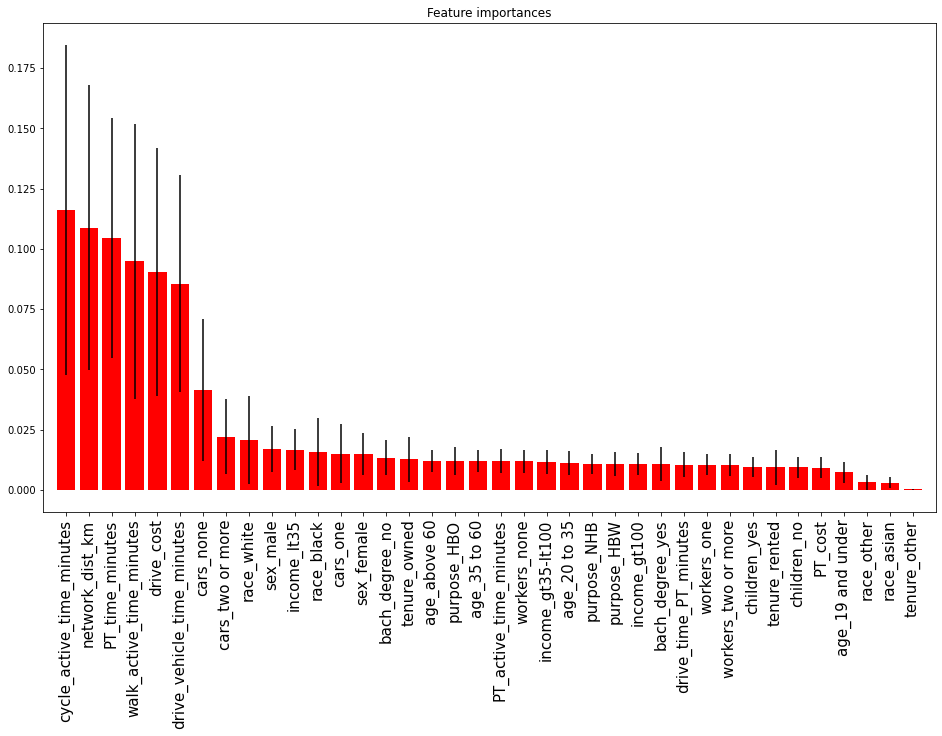

In [16]:
print("Feature ranking:")
for f in range(len(features)):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 9))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()


In [17]:

predicted=rfWinner.predict(X_test)
conf_mat=confusion_matrix(y_test, predicted)
print(conf_mat)
# rows are true labels and coluns are predicted labels
# Cij  is equal to the number of observations 
# known to be in group i but predicted to be in group j.
for i in range(len(conf_mat)):
    print('Total True for Class '+str(i)+': '+str(sum(conf_mat[i])))
    print('Total Predicted for Class '+str(i)+': '+str(sum([p[i] for p in conf_mat])))

PICKLED_MODEL_PATH = "testing/model/trip_mode_rf.p"
RF_FEATURES_LIST_PATH = "testing/model/rf_features.json"
pickle.dump(rfWinner, open(PICKLED_MODEL_PATH, "wb" ) )
json.dump(features,open(RF_FEATURES_LIST_PATH, 'w' ))

[[3375    4   88   16]
 [  13   11    0    0]
 [  64    0  280    7]
 [  29    0    1   51]]
Total True for Class 0: 3483
Total Predicted for Class 0: 3481
Total True for Class 1: 24
Total Predicted for Class 1: 15
Total True for Class 2: 351
Total Predicted for Class 2: 369
Total True for Class 3: 81
Total Predicted for Class 3: 74


In [ ]:
# Logit model

In [19]:
mode_table = create_mode_choice_trip_table(city_folder="Detroit", NHTS_PATH="NHTS/")

ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan
ntransfers_3
nan


In [20]:
mode_table['PT_vehicle_time_minutes']=mode_table['PT_time_minutes']+mode_table['drive_time_PT_minutes']

In [21]:
# generate logit long form data
alt_attrs = {'vehicle_time_minutes': ['drive_vehicle_time_minutes', 'nan', 'nan', 'PT_vehicle_time_minutes'], 
    'active_time_minutes': ['nan', 'cycle_active_time_minutes', 'walk_active_time_minutes', 'PT_active_time_minutes'], 
    'cost': ['drive_cost', 'nan', 'nan', 'PT_cost']
    }
generic_attrs = ['income_gt100', 'income_gt35-lt100', 'income_lt35', 'age_19 and under',
    'age_20 to 35', 'age_35 to 60', 'age_above 60', 'children_no', 'children_yes', 'workers_none', 
    'workers_one', 'workers_two or more', 'tenure_other', 'tenure_owned', 'tenure_rented', 
    'sex_female', 'sex_male', 'bach_degree_no', 'bach_degree_yes', 'cars_none', 'cars_one',
    'cars_two or more', 'race_asian', 'race_black', 'race_other', 'race_white', 
    'purpose_HBW', 'purpose_HBO', 'purpose_NHB',
#            'pop_per_sqmile_home', 
#            'network_dist_km'
    ]
# some of dummy vars have to be excluded as reference levels in categorical vars
exclude_ref = ['income_gt100', 'age_19 and under', 'children_no', 'workers_none',
    'tenure_other', 'sex_female', 'bach_degree_no', 'cars_none', 'race_asian', 'purpose_HBW']
exclude_others = ['tenure_other', 'tenure_owned', 'tenure_rented']  # tenure will cause very large parameters
exclude_generic_attrs = exclude_ref + exclude_others
#        exclude_generic_attrs = exclude_others

# generic_attrs = []
long_data_df = long_form_data(mode_table, alt_attrs=alt_attrs, generic_attrs=generic_attrs, nalt=4)

In [22]:
# Fit Mode Choice Model
alts = {0:'drive', 1:'cycle', 2:'walk', 3:'PT'}
alt_attr_vars = ['vehicle_time_minutes', 'active_time_minutes', 'cost'] 
generic_attrs = [var for var in generic_attrs if var not in exclude_generic_attrs]
constant = True
caseIDs = list(set(long_data_df['group']))
np.random.seed(1)
caseIDs_train = np.random.choice(caseIDs, size=int(len(caseIDs)*0.8), replace=False)
caseIDs_test = [id for id in caseIDs if id not in caseIDs_train]
long_data_df_train = long_data_df.loc[long_data_df['group'].isin(caseIDs_train)].copy()
long_data_df_test = long_data_df.loc[long_data_df['group'].isin(caseIDs_test)].copy()

predict_method = 'max'

In [28]:
model_train, numCoefs = logit_spec(long_data_df_train, alt_attr_vars, generic_attrs, constant=constant, alts=alts)
modelDict_train = logit_est_disp(model_train, numCoefs, nalt=len(alts), disp=True, just_point=False)

Log-likelihood at zero: -21,838.2951
Initial Log-likelihood: -21,838.2951


d:\Anaconda\envs\cusplondon2\lib\site-packages\scipy\optimize\_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 4.08 seconds.
Final log-likelihood: -4,259.9746
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                      choice   No. Observations:               15,753
Model:             Multinomial Logit Model   Df Residuals:                   15,696
Method:                                MLE   Df Model:                           57
Date:                     Wed, 23 Aug 2023   Pseudo R-squ.:                   0.805
Time:                             11:44:24   Pseudo R-bar-squ.:               0.802
AIC:                             8,633.949   Log-Likelihood:             -4,259.975
BIC:                             9,070.842   LL-Null:                   -21,838.295
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
vehicle_time_minutes             -0.0008      

In [29]:
print('\nTraining data performance:\n--------------------------------')
pred_prob_train, y_pred_train, v = asclogit_pred(long_data_df_train, modelDict_train, 
    customIDColumnName='group', alts=alts, method=predict_method, seed=1)
y_true_train = np.array(long_data_df_train['choice']).reshape(-1, len(alts)).argmax(axis=1)
conf_mat_train=confusion_matrix(y_true_train, y_pred_train)
print(conf_mat_train)
print('Accuracy: {:4.4f}, F1 macro: {:4.4f}'.format(
    accuracy_score(y_true_train, y_pred_train), f1_score(y_true_train, y_pred_train, average='macro')
    ))
for i in range(len(conf_mat_train)):
    print('Total True for Class '+alts[i]+': '+str(sum(conf_mat_train[i])))
    print('Total Predicted for Class '+alts[i]+': '+str(sum([p[i] for p in conf_mat_train])))


Training data performance:
--------------------------------
[[13811     0   124    52]
 [  117     0     6     0]
 [  952     0   387     6]
 [  169     0    20   109]]
Accuracy: 0.9082, F1 macro: 0.4578
Total True for Class drive: 13987
Total Predicted for Class drive: 15049
Total True for Class cycle: 123
Total Predicted for Class cycle: 0
Total True for Class walk: 1345
Total Predicted for Class walk: 537
Total True for Class PT: 298
Total Predicted for Class PT: 167


In [30]:
print('\nTest data performance:\n--------------------------------')
pred_prob_test, y_pred_test, v = asclogit_pred(long_data_df_test, modelDict_train, 
    customIDColumnName='group', alts=alts, method=predict_method, seed=1)
y_true_test = np.array(long_data_df_test['choice']).reshape(-1, len(alts)).argmax(axis=1)
conf_mat_test = confusion_matrix(y_true_test, y_pred_test)
print(conf_mat_test)
print('Accuracy: {:4.4f}, F1 macro: {:4.4f}'.format(
    accuracy_score(y_true_test, y_pred_test), f1_score(y_true_test, y_pred_test, average='macro')
    ))
for i in range(len(conf_mat_test)):
    print('Total True for Class '+alts[i]+': '+str(sum(conf_mat_test[i])))
    print('Total Predicted for Class '+alts[i]+': '+str(sum([p[i] for p in conf_mat_test])))


Test data performance:
--------------------------------
[[3426    0   37   15]
 [  27    0    1    0]
 [ 229    0  112    1]
 [  61    0   10   20]]
Accuracy: 0.9033, F1 macro: 0.4275
Total True for Class drive: 3478
Total Predicted for Class drive: 3743
Total True for Class cycle: 28
Total Predicted for Class cycle: 0
Total True for Class walk: 342
Total Predicted for Class walk: 160
Total True for Class PT: 91
Total Predicted for Class PT: 36


In [34]:
model, numCoefs = logit_spec(long_data_df, alt_attr_vars, generic_attrs, constant=constant, alts=alts)
modelDict = logit_est_disp(model, numCoefs, just_point=True, disp=True)

d:\Anaconda\envs\cusplondon2\lib\site-packages\scipy\optimize\_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)




Logit model summary
---------------------------
number of cases:  19692
Initial Log-likelihood:  -27298.908559172884
Final Log-likelihood:  -5395.0525488215335
McFadden R2: 0.8024


Logit model parameters:
---------------------------
vehicle_time_minutes: -0.000862
active_time_minutes: -0.059428
cost: -0.016279
income_gt35-lt100 for cycle: 0.568253
income_gt35-lt100 for walk: -0.152325
income_gt35-lt100 for PT: 0.042825
income_lt35 for cycle: 0.647824
income_lt35 for walk: -0.307614
income_lt35 for PT: 0.383278
age_20 to 35 for cycle: -1.832622
age_20 to 35 for walk: -0.823445
age_20 to 35 for PT: -2.143476
age_35 to 60 for cycle: -1.622197
age_35 to 60 for walk: -0.897388
age_35 to 60 for PT: -2.228831
age_above 60 for cycle: -2.518093
age_above 60 for walk: -1.180555
age_above 60 for PT: -2.555061
children_yes for cycle: -0.443591
children_yes for walk: -0.562573
children_yes for PT: -0.663584
workers_one for cycle: 0.319915
workers_one for walk: 0.662973
workers_one for PT: 0.8746

In [35]:
modelDict

{'just_point': True,
 'model': <pylogit.conditional_logit.MNL at 0x16ba84e38d0>,
 'params': {'vehicle_time_minutes': -0.0008622502110191913,
  'active_time_minutes': -0.05942834522525425,
  'cost': -0.016279338829638702,
  'income_gt35-lt100 for cycle': 0.5682533867243005,
  'income_gt35-lt100 for walk': -0.15232524866448685,
  'income_gt35-lt100 for PT': 0.04282490745050526,
  'income_lt35 for cycle': 0.6478236482775867,
  'income_lt35 for walk': -0.3076140478544313,
  'income_lt35 for PT': 0.38327752347571686,
  'age_20 to 35 for cycle': -1.832622437232299,
  'age_20 to 35 for walk': -0.8234453232272092,
  'age_20 to 35 for PT': -2.143476002621755,
  'age_35 to 60 for cycle': -1.6221968614922233,
  'age_35 to 60 for walk': -0.8973883365177742,
  'age_35 to 60 for PT': -2.228831011028193,
  'age_above 60 for cycle': -2.518093438720669,
  'age_above 60 for walk': -1.1805549340827346,
  'age_above 60 for PT': -2.555061310767505,
  'children_yes for cycle': -0.44359081049752935,
  'child

In [36]:
print('\nAll data performance:\n--------------------------------')
pred_prob, y_pred, v = asclogit_pred(long_data_df, modelDict, 
    customIDColumnName='group', alts=alts, method=predict_method, seed=1)
y_true = np.array(long_data_df['choice']).reshape(-1, len(alts)).argmax(axis=1)
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)
print('Accuracy: {:4.4f}, F1 macro: {:4.4f}'.format(
    accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')
    ))
for i in range(len(conf_mat)):
    print('Total True for Class '+alts[i]+': '+str(sum(conf_mat[i])))
    print('Total Predicted for Class '+alts[i]+': '+str(sum([p[i] for p in conf_mat])))

# The value of time(VoT): (impact/minute)/(impact/dollar) = dollar/minute 
print('VoT Vehicle: '+str(60*modelDict['params']['vehicle_time_minutes']/modelDict['params']['cost']))
print('VoT Active: '+str(60*modelDict['params']['active_time_minutes']/modelDict['params']['cost']))
   


All data performance:
--------------------------------
[[17270     0   148    47]
 [  146     0     5     0]
 [ 1181     0   501     5]
 [  237     0    28   124]]
Accuracy: 0.9087, F1 macro: 0.4534
Total True for Class drive: 17465
Total Predicted for Class drive: 18834
Total True for Class cycle: 151
Total Predicted for Class cycle: 0
Total True for Class walk: 1687
Total Predicted for Class walk: 682
Total True for Class PT: 389
Total Predicted for Class PT: 176
VoT Vehicle: 3.177955395028759
VoT Active: 219.03228078424308
